In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
from loguru import logger
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import skew, kurtosis

from src.universe import Universe
from src.utils import time_series_generator
from src.metrics import plot_mse

2023-04-19 20:51:35.103510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
inception_date = '2022-03-31'
ONE_YEAR_TRADE_DAYS = 252
TWO_YEAR_TRADE_DAYS = ONE_YEAR_TRADE_DAYS * 2
WIN_LEN = 30
UNIVERSE_SIZE = 2500
EPOCH = 20
BATCH_SIZE = 16

In [3]:
universe = Universe()

In [4]:
liquid_ticker_ret = universe.get_liquid_ticker_return('2022-03-31')

/Users/guzhicheng/Desktop/HKUST_course/Spring/6000M/proj2/src/universe.py:13: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  universe = pd.read_csv(self._root / f'{inception_date}.csv', squeeze=True)
100%|██████████| 2500/2500 [00:06<00:00, 391.84it/s]


<Axes: ylabel='Density'>

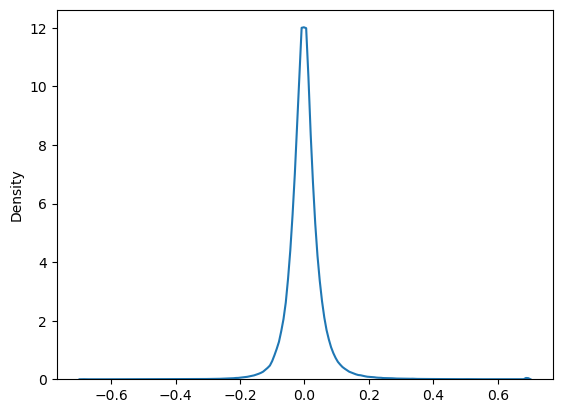

In [27]:
ret_train = liquid_ticker_ret.loc[:inception_date].iloc[-TWO_YEAR_TRADE_DAYS-WIN_LEN:]
train_index = ret_train.loc[:inception_date].iloc[-TWO_YEAR_TRADE_DAYS:].index
train_flat = ret_train.values.flatten()
train_flat = train_flat[train_flat != 0]
m = train_flat.mean()
s = train_flat.std()
train_flat = train_flat.clip(m-2*s, m+2*s)
sns.kdeplot(train_flat)

In [8]:
skew(train_flat), kurtosis(train_flat, fisher=True)

(1.8505625510148498, 25.387383473826496)

In [9]:
ret_train = ret_train.clip(m-2*s, m+2*s)
X, y = time_series_generator(ret_train, WIN_LEN)

In [10]:
y.shape, len(train_index), train_index[-1]

((504, 2500), 504, '2022-03-31')

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X,y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((378, 30, 2500), (126, 30, 2500), (378, 2500), (126, 2500))

In [12]:
lstm_cov = keras.Sequential([
    layers.LSTM(64, dropout=.5, activation='relu', return_sequences=False),
    layers.Dense(UNIVERSE_SIZE),
])

2023-04-19 20:52:07.840450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
lstm_cov.compile(
    optimizer='rmsprop',
    loss='mse',
)
# lstm_cov.build(X_train[0:BATCH_SIZE, :, :])
# lstm_cov.summary()

In [14]:
esc = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='auto',
)

history_lstm_cov = lstm_cov.fit(
    x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=EPOCH, batch_size=BATCH_SIZE)
    

Epoch 1/20
24/24 [==============================] - 2s 28ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 2/20
24/24 [==============================] - 1s 21ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 3/20
24/24 [==============================] - 0s 20ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 4/20
24/24 [==============================] - 0s 19ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 5/20
24/24 [==============================] - 0s 20ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 6/20
24/24 [==============================] - 0s 20ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 7/20
24/24 [==============================] - 0s 19ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 8/20
24/24 [==============================] - 0s 20ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 9/20
24/24 [==============================] - 0s 19ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 10/20
24/24 [==============================] - 0s 19ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 11/

<Axes: >

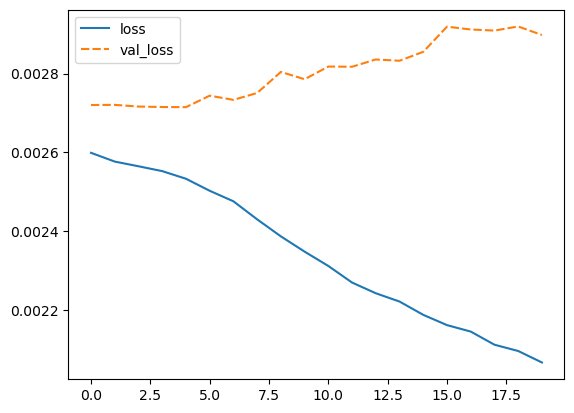

In [15]:
sns.lineplot(history_lstm_cov.history)

In [16]:
## get ticker returns
test_start_date = liquid_ticker_ret.loc[:inception_date].iloc[-WIN_LEN:].index[0]
ret_test = liquid_ticker_ret.loc[test_start_date:].iloc[:ONE_YEAR_TRADE_DAYS + WIN_LEN+1]
ret_test = ret_test.clip(m-2*s, m+2*s)
X_test, y_test = time_series_generator(ret_test, WIN_LEN)

In [17]:
test_index = ret_test.loc[inception_date:].iloc[1:ONE_YEAR_TRADE_DAYS].index
test_index

Index(['2022-04-01', '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
       '2022-04-08', '2022-04-11', '2022-04-12', '2022-04-13', '2022-04-14',
       ...
       '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24',
       '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30', '2023-03-31'],
      dtype='object', length=251)

In [19]:
y_pred_train = lstm_cov.predict(X)
y_pred_test = lstm_cov.predict(X_test)

8/8 [==============================] - 0s 10ms/step


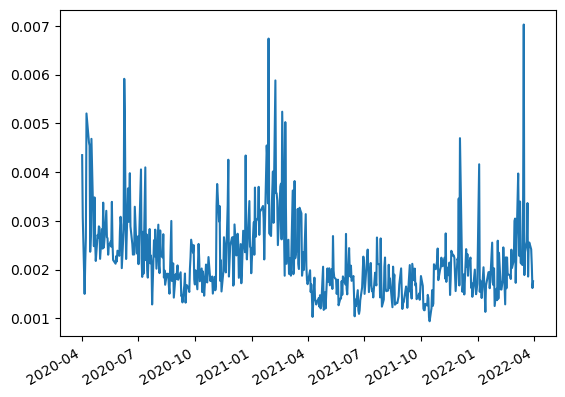

In [20]:
ax_train, mse_df_train = plot_mse(y_pred_train, y, train_index)

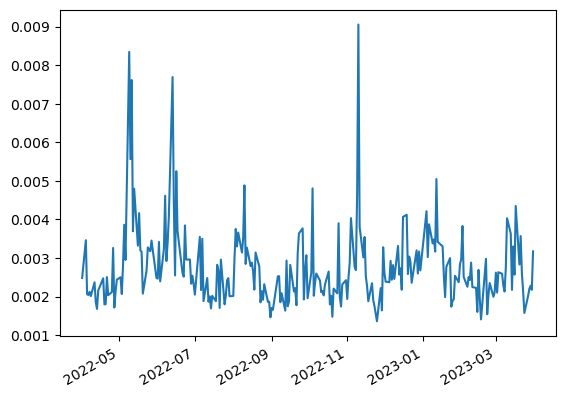

In [24]:
ax_test, mse_df_test = plot_mse(y_pred_test, y_test, test_index)

In [25]:
mse_df_train.mean(), mse_df_train.std()

(0.002211293194719342, 0.0008374875514178456)

In [26]:
mse_df_test.mean(), mse_df_test.mean()

(0.0027579661043877464, 0.0027579661043877464)